**1. Business Understanding**

Airbnb is an online platform that provides home lodging services around the world. Understanding its market values, experiences and rights of host and guest, and safety concerns can be made through data exploration of the previous data.
3 business problems to be observed:
1.	What is the peak season in Seattle in a year?
2.	Which area is the crowdest in Seattle?
3.	Price prediction

**2. Data Understanding**

There are 3 datasets provided:
1.	Calendar, including listing id and price for the availability day.
2.	Listings, including listings information and its scores.
3.	Reviews, including reviewer information and their comments.

2 datasets - Calendar and Listings will be used to analyzed.

Import relevant libraries and required datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

calendar = pd.read_csv('/kaggle/input/seattle/calendar.csv')
listings = pd.read_csv('/kaggle/input/seattle/listings.csv')

In [2]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [3]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [4]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [5]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

**3. Data Preparation**

Convert data types into correct versions on calendar and listings datasets

In [6]:
#Convert integer to string
calendar['listing_id'] = calendar['listing_id'].astype(str)

#Convert to datetime and extract month and year
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['month'] = pd.to_datetime(calendar['date']).dt.month

#Eliminate and convert to float
calendar['price'] = calendar['price'].replace('\$|,', '', regex=True).astype('float')

In [7]:
calendar.head()

,listing_id,date,available,price,month
0,241032,2016-01-04,t,85.0,1
1,241032,2016-01-05,t,85.0,1
2,241032,2016-01-06,f,NaN,1
3,241032,2016-01-07,f,NaN,1
4,241032,2016-01-08,f,NaN,1


In [8]:
#Create new datast for related features 
df = listings[['price','accommodates','bathrooms','bedrooms',
               'beds','weekly_price','monthly_price','cleaning_fee', 
               'instant_bookable','reviews_per_month','cancellation_policy']]
df.head()

,price,accommodates,bathrooms,bedrooms,beds,weekly_price,monthly_price,cleaning_fee,instant_bookable,reviews_per_month,cancellation_policy
0,$85.00,4,1.0,1.0,1.0,NaN,NaN,NaN,f,4.07,moderate
1,$150.00,4,1.0,1.0,1.0,"$1,000.00","$3,000.00",$40.00,f,1.48,strict
2,$975.00,11,4.5,5.0,7.0,NaN,NaN,$300.00,f,1.15,strict
3,$100.00,3,1.0,0.0,2.0,$650.00,"$2,300.00",NaN,f,NaN,flexible
4,$450.00,6,2.0,3.0,3.0,NaN,NaN,$125.00,f,0.89,strict


From df dataset, there are incorrect data types and NaN values.

In [9]:
#Convert data type string into float
df[['price', 'weekly_price', 'monthly_price', 'cleaning_fee']] = df.iloc[:, [0,5,6,7]].replace('\$|,', '', regex = True).astype('float')

df.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,price,accommodates,bathrooms,bedrooms,beds,weekly_price,monthly_price,cleaning_fee,instant_bookable,reviews_per_month,cancellation_policy
0,85.0,4,1.0,1.0,1.0,NaN,NaN,NaN,f,4.07,moderate
1,150.0,4,1.0,1.0,1.0,1000.0,3000.0,40.0,f,1.48,strict
2,975.0,11,4.5,5.0,7.0,NaN,NaN,300.0,f,1.15,strict
3,100.0,3,1.0,0.0,2.0,650.0,2300.0,NaN,f,NaN,flexible
4,450.0,6,2.0,3.0,3.0,NaN,NaN,125.0,f,0.89,strict


**Imputing Values in Numerical Variable**

NaN values in the data frame can be imputed with mean value of the columns to prevent dropping of rows or columns. 

In [10]:
#Impute values 
num_vars = df.select_dtypes(include=['int', 'float']).columns
for num in num_vars:
    df[num].fillna(df[num].mean(), inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


**Create dummies to NaN values in Categorical Variable**

 Categorical variable column break into 1 or 0 groups and summarize into column dummy_na.

In [11]:
#Break NaN values into dummy coded
cat_vars = df.select_dtypes(include=['object']).columns
for cat in cat_vars:
    df = pd.concat([df.drop(cat, axis=1), pd.get_dummies(df[cat], prefix = cat, prefix_sep = '_', drop_first = True)],  axis = 1)

In [12]:
#Check for null
np.sum(df.isnull())

price                           0
accommodates                    0
bathrooms                       0
bedrooms                        0
beds                            0
weekly_price                    0
monthly_price                   0
cleaning_fee                    0
reviews_per_month               0
instant_bookable_t              0
cancellation_policy_moderate    0
cancellation_policy_strict      0
dtype: int64

NaN values have been fully replaced.

**4. Modelling & Evaluation**

Questions 1: What is the peak season in Seattle in a year??

In [13]:
#Extract count of 'f' from available's column
calendar_f = pd.pivot_table(calendar[calendar['available'] == 'f'], index= 'month', aggfunc = {'available': 'count'})
calendar_f['month'] = calendar_f.index

#Extract count of 't' from available's column
calendar_t = pd.pivot_table(calendar[calendar['available'] == 't'], index= 'month', aggfunc = {'available': 'count'})
calendar_t['month'] = calendar_t.index

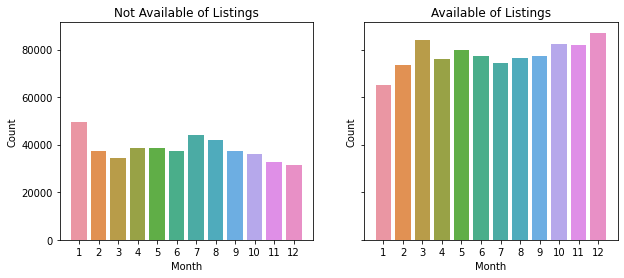

In [14]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (10, 4))
f = sns.barplot(x = calendar_f['month'], y = calendar_f['available'], ax = ax0)
t = sns.barplot(x = calendar_t['month'], y = calendar_t['available'], ax = ax1)
ax0.set(xlabel = 'Month', ylabel = 'Count', xlim = (-1, 12))
ax1.set(xlabel = 'Month', ylabel = 'Count', xlim = (-1, 12))
f.set_title('Not Available of Listings', y = 1)
t.set_title('Available of Listings', y = 1)
plt.show()

From the graphs above, the peak season in Seattle was observed in January, June, and August throughout the year. More listings were available in March and December.

**Question 2: Which area is the crowdest in Seattle?**

In [15]:
listings['zipcode'] = listings['zipcode'].dropna(axis = 0).astype('category')
location = listings[['latitude', 'longitude', 'zipcode']]

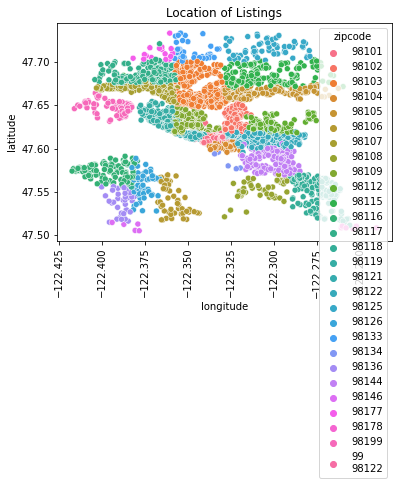

In [16]:
sns.scatterplot(data = location, x = 'longitude', y = 'latitude', hue = 'zipcode').set(title = 'Location of Listings')
sns.set(rc = {'figure.figsize':(10,15)})
plt.xticks(rotation = 90)
plt.show()

From the scatter plot above, most of the listings are located at the center of Seattle with zip codes 98122, 98103, and 98102.

**Question 3: Price prediction**

Several features have been selected from listings dataset.

In [17]:
df.head()

,price,accommodates,bathrooms,bedrooms,beds,weekly_price,monthly_price,cleaning_fee,reviews_per_month,instant_bookable_t,cancellation_policy_moderate,cancellation_policy_strict
0,85.0,4,1.0,1.0,1.0,788.481832,2613.33619,61.710904,4.070000,0,1,0
1,150.0,4,1.0,1.0,1.0,1000.000000,3000.00000,40.000000,1.480000,0,0,1
2,975.0,11,4.5,5.0,7.0,788.481832,2613.33619,300.000000,1.150000,0,0,1
3,100.0,3,1.0,0.0,2.0,650.000000,2300.00000,61.710904,2.078919,0,0,0
4,450.0,6,2.0,3.0,3.0,788.481832,2613.33619,125.000000,0.890000,0,0,1


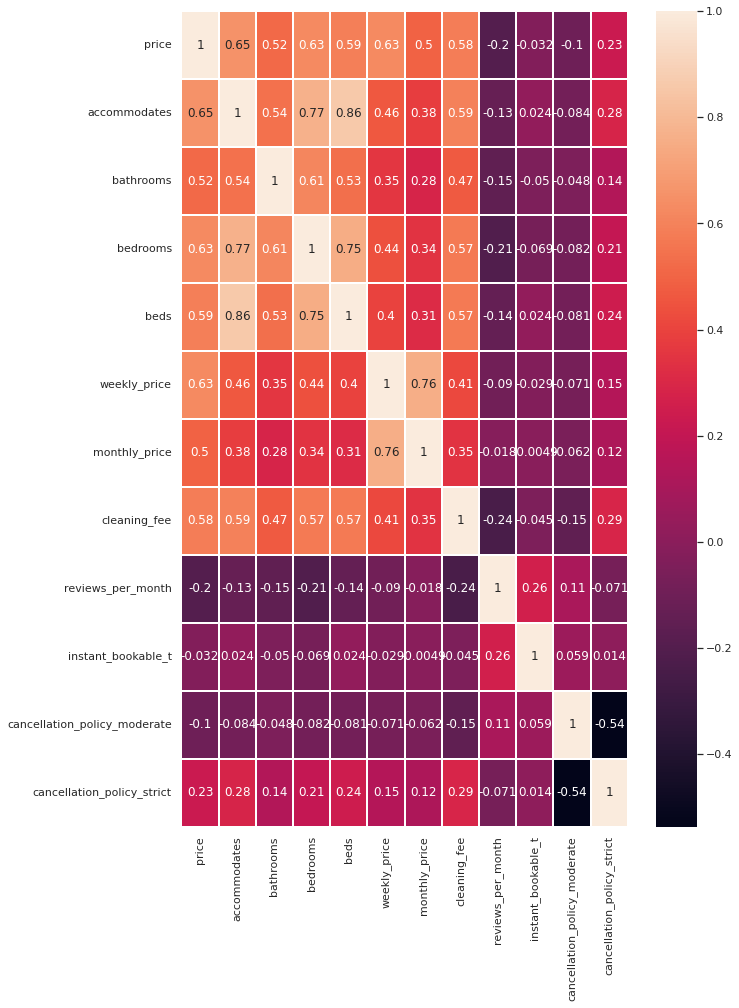

<Figure size 360x360 with 0 Axes>

In [18]:
#Overview the correlation of price
sns.heatmap(df.corr(), annot = True, linewidths = .3)
plt.figure(figsize = (5, 5))
plt.show()

In [19]:
#Define X and y 
y = df['price']
df = df.drop('price', axis = 1)
X = df

In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   accommodates                  3818 non-null   int64  
 1   bathrooms                     3818 non-null   float64
 2   bedrooms                      3818 non-null   float64
 3   beds                          3818 non-null   float64
 4   weekly_price                  3818 non-null   float64
 5   monthly_price                 3818 non-null   float64
 6   cleaning_fee                  3818 non-null   float64
 7   reviews_per_month             3818 non-null   float64
 8   instant_bookable_t            3818 non-null   uint8  
 9   cancellation_policy_moderate  3818 non-null   uint8  
 10  cancellation_policy_strict    3818 non-null   uint8  
dtypes: float64(7), int64(1), uint8(3)
memory usage: 249.9 KB


In [21]:
#Instantiate model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)
lm_model = LinearRegression(normalize = True)

#Fit the model
lm_model.fit(X_train, y_train)

#Predict fitted model on test data
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print('rsquared_score: {} \ntrain_score: {}'.format(test_score, train_score))

rsquared_score: 0.6106924826212423 
train_score: 0.6127076826643214


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


Based on the rsqueared score and train score, both data fits well.

In [22]:
#Create dataframe to understand the most influential coefficients in a linear model
coef_df = pd.DataFrame()
coef_df['features'] = X_train.columns
coef_df['coef'] = lm_model.coef_
coef_df['abs_coef'] = np.abs(lm_model.coef_)
coef_df = coef_df.sort_values('abs_coef', ascending = False)
print('Weight of Features on Price:\n', coef_df, '\n')

Weight of Features on Price:
                         features       coef   abs_coef
1                      bathrooms  16.965889  16.965889
0                   accommodates  11.605794  11.605794
2                       bedrooms  10.722350  10.722350
7              reviews_per_month  -3.330174   3.330174
3                           beds  -2.768310   2.768310
9   cancellation_policy_moderate  -2.033063   2.033063
8             instant_bookable_t   2.009741   2.009741
10    cancellation_policy_strict   0.520683   0.520683
6                   cleaning_fee   0.393119   0.393119
4                   weekly_price   0.082866   0.082866
5                  monthly_price   0.001238   0.001238 



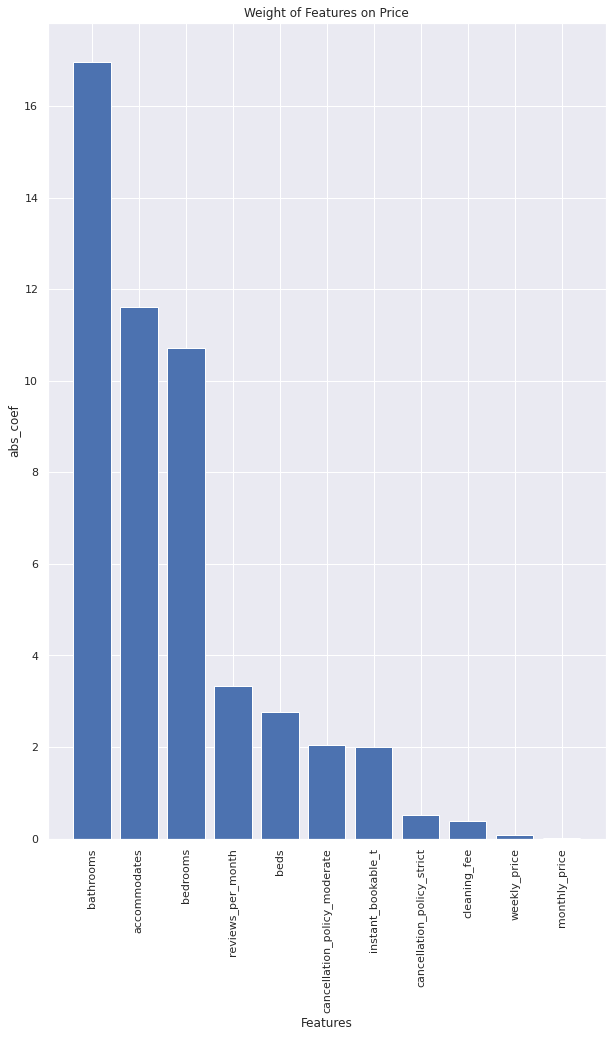

<Figure size 1080x360 with 0 Axes>

In [23]:
plt.bar(coef_df['features'], coef_df['abs_coef'])
plt.xlabel('Features')
plt.ylabel('abs_coef')
plt.title('Weight of Features on Price')
plt.xticks(coef_df['features'], rotation = 90)
plt.figure(figsize = (15,5))
plt.show()

Features of bathrooms, accommodation, and bedrooms show many contribution to the price.

**Summary**

From the analysis, the Airbnb business in Seattle reached its maximum in January, July, and August. Most of the listings are located at the center of Seattle. Price is defined by the bathrooms, accommodation, bedrooms of listings.